Importing the header files

In [3]:
import gmsh
import os
import numpy as np
import matplotlib.pyplot as plt

from mpi4py import MPI
from petsc4py import PETSc

from basix.ufl import element, mixed_element, quadrature_element

from dolfinx import fem, mesh, io, plot, log
from dolfinx.cpp.mesh import to_type, cell_entity_type
from dolfinx.fem import (Constant, Function, functionspace, Expression,
                         assemble_scalar, dirichletbc, form, locate_dofs_topological, set_bc)
from dolfinx.fem.petsc import (apply_lifting, assemble_matrix, assemble_vector,
                               create_vector, create_matrix, set_bc, NonlinearProblem)
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.graph import adjacencylist
from dolfinx.geometry import bb_tree, compute_collisions_points, compute_colliding_cells
from dolfinx.io import (VTXWriter, distribute_entity_data, gmshio, XDMFFile)
from dolfinx.mesh import create_mesh, meshtags_from_entities
import ufl
from ufl import (TestFunctions, CellDiameter, TrialFunction, Identity, nabla_grad, grad, sym, det, div, dev, inv, tr, sqrt, conditional ,\
                 gt, dx, ds, inner, derivative, dot, ln, split, exp, eq, cos, acos, ge, le, FacetNormal, as_vector)

Generation of mesh using gmsh

In [4]:
gmsh.initialize()

L = 2.2
H = 0.41
c_x = c_y = 0.2
r = 0.05
gdim = 2
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
model_rank = 0
if comm.rank == model_rank:
    rectangle = gmsh.model.occ.addRectangle(0, 0, 0, L, H, tag=1)
    obstacle = gmsh.model.occ.addDisk(c_x, c_y, 0, r, r)

In [6]:
if comm.rank == model_rank:
    fluid = gmsh.model.occ.cut([(gdim, rectangle)], [(gdim, obstacle)])
    gmsh.model.occ.synchronize()

Creation of Fluid marker for the mesh

In [7]:
fluid_marker = 6
if comm.rank == model_rank:
    volumes = gmsh.model.getEntities(dim=gdim)
    assert (len(volumes) == 1)
    gmsh.model.addPhysicalGroup(volumes[0][0], [volumes[0][1]], fluid_marker)
    gmsh.model.setPhysicalName(volumes[0][0], fluid_marker, "Fluid")

Marking the boundaries and cylinder

In [8]:
inlet_marker, outlet_marker, top_wall_marker, bottom_wall_marker, obstacle_marker = 1, 2, 3, 4, 5
inflow, outflow, topwall, bottomwall, obstacle = [], [], [], [], []
if comm.rank == model_rank:
    boundaries = gmsh.model.getBoundary(volumes, oriented=False)
    for boundary in boundaries:
        center_of_mass = gmsh.model.occ.getCenterOfMass(boundary[0], boundary[1])
        if np.allclose(center_of_mass, [0, H / 2, 0]):
            inflow.append(boundary[1])
        elif np.allclose(center_of_mass, [L, H / 2, 0]):
            outflow.append(boundary[1])
        elif np.allclose(center_of_mass, [L / 2, H, 0]): 
            topwall.append(boundary[1])
        elif np.allclose(center_of_mass, [L / 2, 0, 0]):
            bottomwall.append(boundary[1])
        else:
            obstacle.append(boundary[1])
    gmsh.model.addPhysicalGroup(1, topwall, top_wall_marker)
    gmsh.model.setPhysicalName(1, top_wall_marker, "TopWall")
    gmsh.model.addPhysicalGroup(1, bottomwall, bottom_wall_marker)
    gmsh.model.setPhysicalName(1, bottom_wall_marker, "BottomWall")
    gmsh.model.addPhysicalGroup(1, inflow, inlet_marker)
    gmsh.model.setPhysicalName(1, inlet_marker, "Inlet")
    gmsh.model.addPhysicalGroup(1, outflow, outlet_marker)
    gmsh.model.setPhysicalName(1, outlet_marker, "Outlet")
    gmsh.model.addPhysicalGroup(1, obstacle, obstacle_marker)
    gmsh.model.setPhysicalName(1, obstacle_marker, "Obstacle")

In [9]:
# Create distance field from obstacle.
# Add threshold of mesh sizes based on the distance field
# LcMax -                  /--------
#                      /
# LcMin -o---------/
#        |         |       |
#       Point    DistMin DistMax
res_min = r / 3
if comm.rank == model_rank:
    distance_field = gmsh.model.mesh.field.add("Distance")
    gmsh.model.mesh.field.setNumbers(distance_field, "EdgesList", obstacle)
    threshold_field = gmsh.model.mesh.field.add("Threshold")
    gmsh.model.mesh.field.setNumber(threshold_field, "IField", distance_field)
    gmsh.model.mesh.field.setNumber(threshold_field, "LcMin", res_min)
    gmsh.model.mesh.field.setNumber(threshold_field, "LcMax", 0.25 * H)
    gmsh.model.mesh.field.setNumber(threshold_field, "DistMin", r)
    gmsh.model.mesh.field.setNumber(threshold_field, "DistMax", 2 * H)
    min_field = gmsh.model.mesh.field.add("Min")
    gmsh.model.mesh.field.setNumbers(min_field, "FieldsList", [threshold_field])
    gmsh.model.mesh.field.setAsBackgroundMesh(min_field)

In [10]:
if comm.rank == model_rank:
    gmsh.option.setNumber("Mesh.Algorithm", 8)
    gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 2)
    gmsh.option.setNumber("Mesh.RecombineAll", 1)
    gmsh.option.setNumber("Mesh.SubdivisionAlgorithm", 1)
    gmsh.model.mesh.generate(gdim)
    gmsh.model.mesh.setOrder(2)
    gmsh.model.mesh.optimize("Netgen")

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 5 (Ellipse)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 70%] Meshing curve 8 (Line)
Info    : [ 90%] Meshing curve 9 (Line)
Info    : Done meshing 1D (Wall 0.00512839s, CPU 0.003479s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay for Quads)
Info    : Simple recombination completed (Wall 0.0017363s, CPU 0.001737s): 103 quads, 16 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.82361, min Q = 0.425555
Info    : Simple recombination completed (Wall 0.00250896s, CPU 0.002408s): 460 quads, 0 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.865979, min Q = 0.499255
Info    : Done meshing 2D (Wall 0.00700647s, CPU 0.006498s)
Info    : Refining mesh...
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0%] Meshing curve 5 order 2
Info    : [ 20%] Meshing curve 6 order 2
Info    : [ 40%] Meshing curve 7 order 2
Info    : [ 60%] Meshi

In [11]:
msh, markers, facet_tags = gmshio.model_to_mesh(gmsh.model, comm, model_rank, gdim=gdim)
facet_tags.name = "Facet markers"

Constants

In [12]:
t = 0
T = 8             # Final time
dt = 1/160  # Time step size
num_steps = int(T / dt)
k = Constant(msh, PETSc.ScalarType(dt))
mu = Constant(msh, PETSc.ScalarType(0.001))  # Dynamic viscosity
rho = Constant(msh, PETSc.ScalarType(1))     # Density
Ren = Constant(msh, PETSc.ScalarType(100.0))
nu = 1/Ren

num_steps = np.int32(T/dt) + 1

Defining the elements and function space

In [13]:
# coordinates of the nodes
x = ufl.SpatialCoordinate(msh)

# Defining the volume integration measure "dx" 
# also specifing the number of volume quadrature points.
dx = ufl.Measure('dx', domain=msh, metadata={'quadrature_degree': 4})
ds = ufl.Measure('ds', domain=msh, subdomain_data=facet_tags, metadata={'quadrature_degree': 4})

# FE Elements
# Quadratic element used
# Defining the order of function spaces and elements
deg_u = 1
deg_p = deg_u

# velocity
Ucg2 = element("Lagrange", msh.basix_cell(), deg_u, shape=(msh.geometry.dim,))
# pressure
Pcg1 = element("Lagrange", msh.basix_cell(), deg_p)

# Mixed element
Mcg = mixed_element([Ucg2, Pcg1])
ME = functionspace(msh, Mcg)

V2 = functionspace(msh, Ucg2) # Velocity function space
Q1 = functionspace(msh, Pcg1) # Pressure function space

# functions with DOFs at the current step
w = Function(ME)
u, p = split(w)

# functions with DOFs at the previous step
w_old = Function(ME)
u_old, p_old = split(w_old)

# functions with DOFs at the another previous step
w_old2 = Function(ME)
u_old2, p_old2 = split(w_old2)

# Test functions
v, q = TestFunctions(ME)

# current acceleration
a_new = Function(V2)

# old acceleration
a_old = Function(V2)

# Trial functions
dw = TrialFunction(ME)

Defining boundary conditions and inlet velocity

In [14]:
# Boundary conditions
'''
1 1 "inlet"
1 2 "outlet"
1 3 "topedge"
1 4 "bottomedge"
1 5 "cylinder"
2 6 "fluid"
'''

dofs_1_x = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(1)) #vx
dofs_1_y = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(1)) #vy

dofs_3_y = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(3)) #uy
dofs_4_y = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(4)) #uy

dofs_5_x = fem.locate_dofs_topological(ME.sub(0).sub(0), facet_tags.dim, facet_tags.find(5)) #ux
dofs_5_y = fem.locate_dofs_topological(ME.sub(0).sub(1), facet_tags.dim, facet_tags.find(5)) #uy

class InletVelocity():
    def __init__(self, t):
        self.t = t

    def __call__(self, x):
        values = np.zeros((gdim, x.shape[1]), dtype=PETSc.ScalarType)
        values[0] = 4 * 1.5 * np.sin(self.t * np.pi / 8) * x[1] * (0.41 - x[1]) / (0.41**2)
        #values = 1.0
        return values

bc1_x = fem.dirichletbc(value=1.0, dofs=dofs_1_x, V=ME.sub(0).sub(0))
bc1_y = fem.dirichletbc(value=0.0, dofs=dofs_1_y, V=ME.sub(0).sub(1))

bc3_y = fem.dirichletbc(value=0.0, dofs=dofs_3_y, V=ME.sub(0).sub(1))
bc4_y = fem.dirichletbc(value=0.0, dofs=dofs_4_y, V=ME.sub(0).sub(1))

bc5_x = fem.dirichletbc(value=0.0, dofs=dofs_5_x, V=ME.sub(0).sub(0))
bc5_y = fem.dirichletbc(value=0.0, dofs=dofs_5_y, V=ME.sub(0).sub(1))


bcs = [bc1_x, bc1_y, bc3_y, bc4_y, bc5_x, bc5_y]

Integration of the developed formulation

In [16]:
# time integration parameters
# generalised-alpha method
specRad = 0.0
alpf = 1.0/(1.0+specRad)
alpm = 0.5*(3.0-specRad)/(1.0+specRad)
gamm = 0.5+alpm-alpf

# dimension
d = len(u)

# Kinematics
Id = Identity(d)

u_avg = alpf*u + (1.0-alpf)*u_old
p_avg = alpf*p + (1.0-alpf)*p_old
a = (1.0/gamm/dt)*(u-u_old) + ((gamm-1.0)/gamm)*a_old
# expression for copying/storing the values
a_expr = Expression(a, V2.element.interpolation_points())
a_avg = alpm*a + (1.0-alpm)*a_old

# Weak form: time discretized 
#Res = rho*inner(dot(2*u_old-u_old2, nabla_grad(u)), v)*dx + mu*inner(grad(u), grad(v))*dx - inner(p, div(v))*dx + inner(div(u), q)*dx
Res =  rho*inner(a_avg, v)*dx
Res += rho*inner(dot(u_old, nabla_grad(u_avg)), v)*dx 
Res += rho*inner(dot(u_avg, nabla_grad(u_old)), v)*dx 
Res -= rho*inner(dot(u_old, nabla_grad(u_old)), v)*dx 
#Res =  rho*inner(dot(2*u_old-u_old2, nabla_grad(u_avg)), v)*dx
#Res =  rho*inner(dot(u_old, nabla_grad(u_avg)), v)*dx
Res += mu*inner(grad(u_avg), grad(v))*dx
Res -= inner(p_avg, div(v))*dx
Res -= inner(div(u_avg), q)*dx

# SUPG stabilization parameters 
h = Constant(msh, 0.001)
u_mag = sqrt(dot(u_old, u_old)) 
tau_SUPG = 1.0 / sqrt((2.0 / dt)**2 + (u_mag / h)**2 + (4.0 * nu / h**2)**2)
tau_PSPG = tau_SUPG
tau_LSIC = h * u_mag/2
# Momentum equation residual 
Rm = rho * (dot(u_old, nabla_grad(u_old)) - grad(p_avg)) - mu * div(grad(u_old)) 
# Continuity equation residual 
Rc = div(u_old) 
# SUPG stabilization terms 
Res += tau_SUPG * inner(Rm, dot(u_old, nabla_grad(v))) * dx 
# PSPG stabilization terms 
Res += tau_PSPG * inner(Rm, grad(q)) * dx
# LSIC stabilization terms
Res += tau_LSIC * inner(div(u), div(v)) * dx
dRes = derivative(Res, w, dw)

# set up the nonlinear problem
problem = NonlinearProblem(Res, w, bcs, dRes)

Calling the solver and time loop

In [17]:
# set the solver parameters
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-6
solver.atol = 1e-6
solver.max_it = 50
solver.report = True

#  The Krylov solver parameters.
ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "preonly"
opts[f"{option_prefix}pc_type"] = "lu"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
opts[f"{option_prefix}ksp_max_it"] = 30
ksp.setFromOptions()

#setting up the cylinder as obstacle
n = -FacetNormal(msh)  # Normal pointing out of obstacle
obstacle_marker = 5
dObs = ufl.Measure("ds", domain=msh, subdomain_data=facet_tags, subdomain_id=obstacle_marker)
u_t = inner(as_vector((n[1], -n[0])), u)
# lift and drag calculation on the cylinder
#drag = form(2 / 0.1 * (mu / rho * inner(grad(u_t), n) * n[0] - p * n[0]) * dObs)
#lift = form(-2 / 0.1 * (mu / rho * inner(grad(u_t), n) * n[1] + p * n[1]) * dObs)
drag = form( ( (mu*grad(u)[0,0]-p)*n[0] + (mu*grad(u)[0,1])*n[1] )   * dObs)
lift = form( ( (mu*grad(u)[1,0])*n[0]   + (mu*grad(u)[1,1]-p)*n[1] ) * dObs)
if msh.comm.rank == 0:
    C_D = np.zeros(num_steps, dtype=PETSc.ScalarType)
    C_L = np.zeros(num_steps, dtype=PETSc.ScalarType)
    accumulated_drag = 0.0 
    accumulated_lift = 0.0
    
# velocity projection
U1 = element("Lagrange", msh.basix_cell(), 1, shape=(msh.geometry.dim,))
Vs = functionspace(msh, U1)

u_proj = Function(Vs)
u_proj.name = "velocity"
p_proj = Function(Q1)
p_proj.name = "pressure"

fname = "./results/cylinder2d-velo-.pvd"
VTKfile_Velo = io.VTKFile(msh.comm, fname, "w")
VTKfile_Velo.write_mesh(msh)

fname = "./results/cylinder2d-pres-.pvd"
VTKfile_Pres = io.VTKFile(msh.comm, fname, "w")
VTKfile_Pres.write_mesh(msh)

# function to write results to XDMF at time t
def writeResults_Velo(time_cur, timeStep):
    u_proj.interpolate(w.sub(0))
    #    file.close()
    VTKfile_Velo.write_function(u_proj)

# function to write results to XDMF at time t
def writeResults_Pres(time_cur, timeStep):
    p_proj.interpolate(w.sub(1))
    VTKfile_Pres.write_function(p_proj)

fname = "Cylinder2D-Re100-forces-coupled.dat"
file_forces = open(fname,"w")

print("\n----------------------------\n")
print("Simulation has started")
print("\n----------------------------\n")

timeStep = 0
time_cur = 0.0

writeResults_Velo(time_cur, timeStep)
writeResults_Pres(time_cur, timeStep)
print(time_cur, 0.0, 0.0, file=file_forces)

# looping over time steps
#for timeStep in range(num_steps):
while ( round(time_cur+dt, 6) <= T):
    # Updating current time
    time_cur += dt
    timeStep += 1

    print("\n\n Load step = ", timeStep)
    print("     Time      = ", time_cur)

    # Solving the problem
    (num_its, converged) = solver.solve(w)

    if converged:
        print(f"Converged in {num_its} iterations.")
    else:
        print(f"Not converged.")

    # computing new acceleration
    a_new.interpolate(a_expr)

    writeResults_Velo(time_cur, timeStep)
    writeResults_Pres(time_cur, timeStep)

    # saving variables
    # velocity
    w_old.vector.copy(w_old2.vector)
    w.vector.copy(w_old.vector)

    # acceleration
    a_new.vector.copy(a_old.vector)

    # assembling the coefficient values
    drag_coeff = assemble_scalar(drag)
    lift_coeff = assemble_scalar(lift)
    
    print(drag_coeff, lift_coeff)
    if msh.comm.rank == 0: 
        accumulated_drag = drag_coeff 
        accumulated_lift = lift_coeff 
        C_D[timeStep] = accumulated_drag 
        C_L[timeStep] = accumulated_lift 
        print(time_cur, drag_coeff, lift_coeff, file=file_forces)

VTKfile_Velo.close()
VTKfile_Pres.close()
file_forces.close()


----------------------------

Simulation has started

----------------------------



 Load step =  1
     Time      =  0.00625
Converged in 2 iterations.
4.327297084575623 0.010651251563070702


 Load step =  2
     Time      =  0.0125
Converged in 2 iterations.
-1.2211871269090195 -0.009162697073955131


 Load step =  3
     Time      =  0.018750000000000003
Converged in 2 iterations.
0.09063816592016324 -0.0018081036792185928


 Load step =  4
     Time      =  0.025
Converged in 2 iterations.
0.10316434986417747 -0.0007158291385141801


 Load step =  5
     Time      =  0.03125
Converged in 2 iterations.
0.09405103182474006 4.303870242250126e-05


 Load step =  6
     Time      =  0.0375
Converged in 2 iterations.
0.09027348820656635 0.0007412478493434528


 Load step =  7
     Time      =  0.04375
Converged in 2 iterations.
0.08827723925925518 0.0013491855960807355


 Load step =  8
     Time      =  0.049999999999999996
Converged in 2 iterations.
0.08733204848905683 0.0018428002

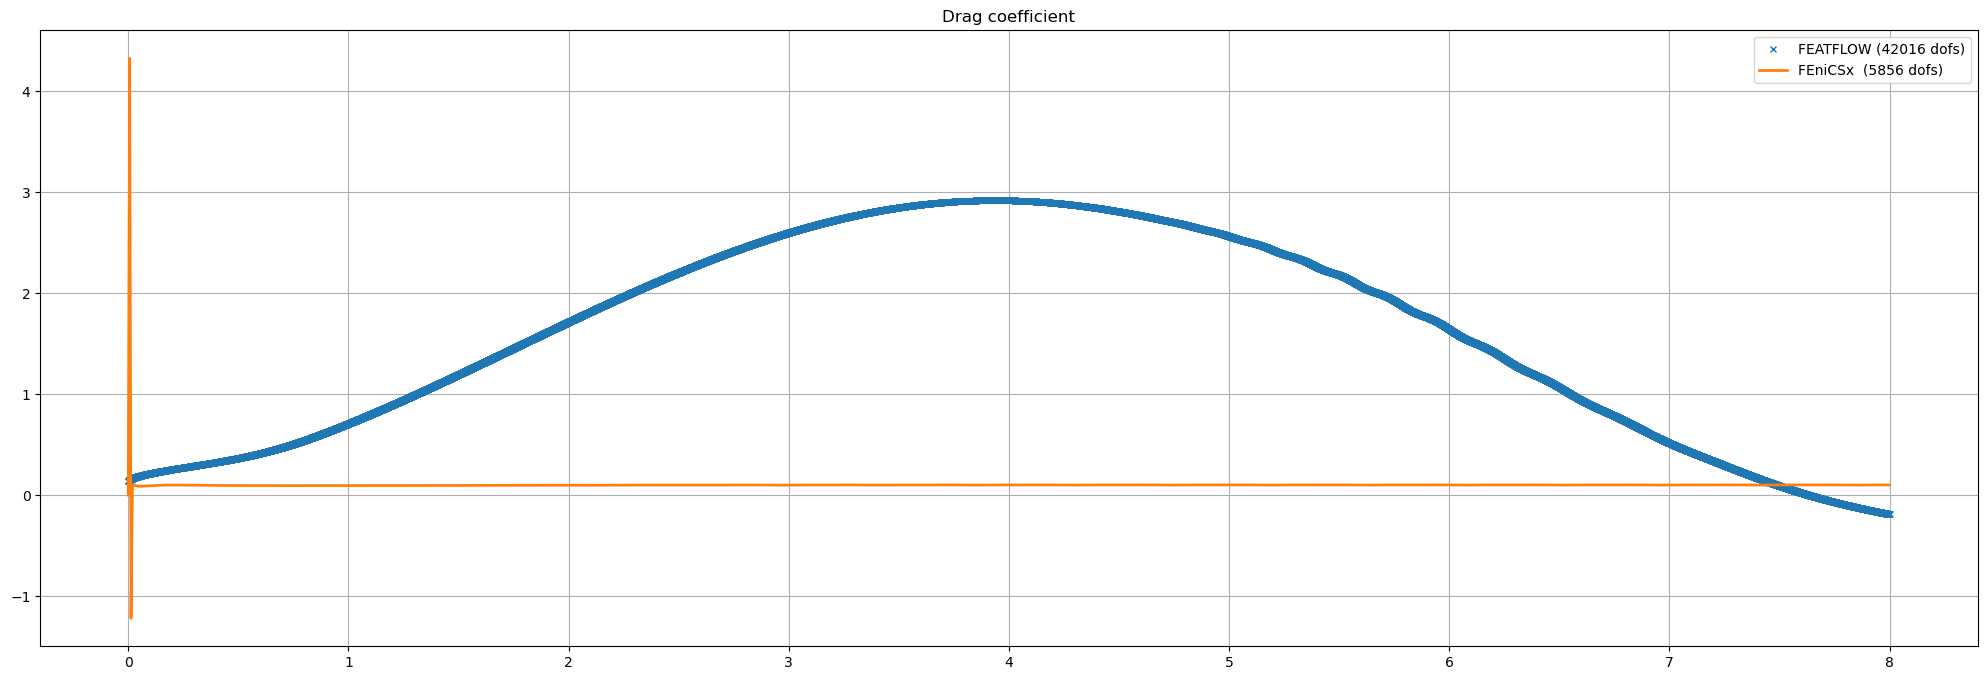

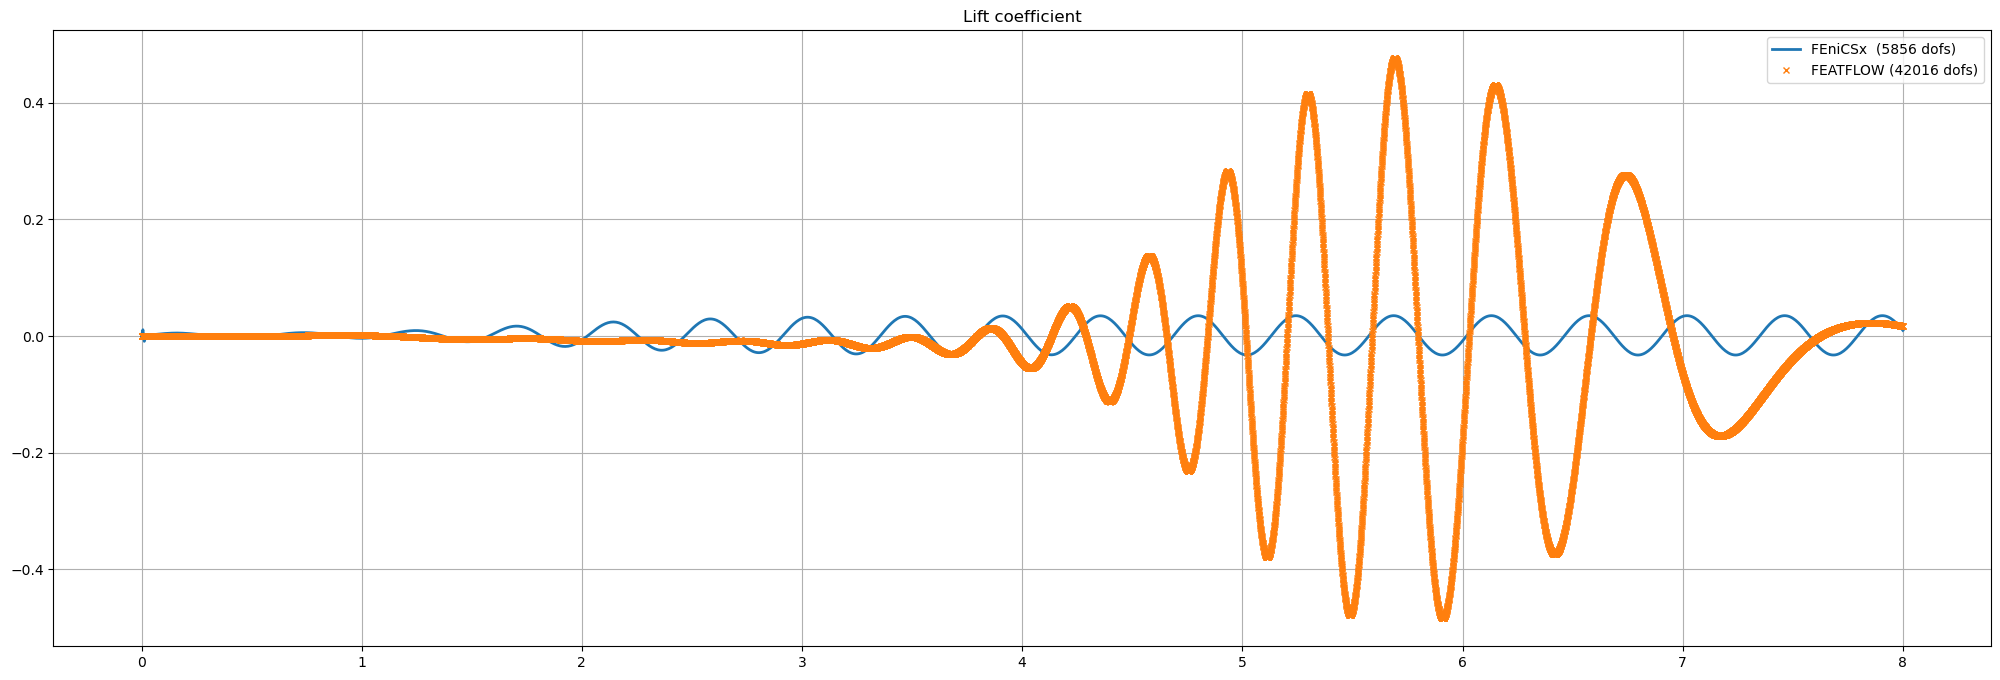

In [18]:
# Ensure you only run the plotting code on the master process
if msh.comm.rank == 0:
    if not os.path.exists("figures"):
        os.mkdir("figures")

    # Calculate number of degrees of freedom for velocity and pressure
    num_velocity_dofs = V2.dofmap.index_map_bs * V2.dofmap.index_map.size_global
    num_pressure_dofs = Q1.dofmap.index_map_bs * V2.dofmap.index_map.size_global

    # Load reference data from FEATFLOW
    turek = np.loadtxt("bdforces_lv4")

    # Ensure timeStep and C_D are numpy arrays
    timeStep = np.linspace(0, 8+0, 1281)
    C_D = np.array(C_D)  # Ensure C_D is a numpy array
    C_L = np. array(C_L)

    # Sample the data
    time_featflow = turek[1:, 1] # the first column is time
    drag_featflow = turek[1:, 3] # the third column is drag coefficient
    lift_featflow = turek[1:, 4] # the 5th column is the lift coefficient

    # Create plot
    fig = plt.figure(figsize=(25, 8))
    l2 = plt.plot(time_featflow, drag_featflow, marker="x", linestyle="", markersize=4, label="FEATFLOW (42016 dofs)")
    l1 = plt.plot(timeStep, C_D, label=r"FEniCSx  ({0:d} dofs)".format(num_velocity_dofs + num_pressure_dofs), linewidth=2)
   
    # turek_p = np.loadtxt("pointvalues_lv4")
    plt.title("Drag coefficient")
    plt.grid()
    plt.legend()
    plt.savefig("figures/drag_comparison.png")
    
    fig = plt.figure(figsize=(25, 8))
    l1 = plt.plot(timeStep, C_L, label=r"FEniCSx  ({0:d} dofs)".format(num_velocity_dofs + num_pressure_dofs), linewidth=2)
    l2 = plt.plot(time_featflow, lift_featflow, marker="x",
                  linestyle="", markersize=4, label="FEATFLOW (42016 dofs)")
    plt.title("Lift coefficient")
    plt.grid()
    plt.legend()
    plt.savefig("figures/lift_comparison.png")
